# Weighting and Aggregating

This notebook will take a look at a few methods for weigthing and aggregating our final data. These include:
- Weighting by PCA and Factor Analysis
- Weighting by Unobserved Component Analysis
- Weighting by Data Envelopment Analysis
- Additive Aggregation
- Geometric Aggregation

Before beginning, we'll need to read in our data, impute missing values, and normalize it. We will do the following:
- Impute costa_km with zeroes, and all other missing variables with median values
- Normalize the data using ranking

I'll read in the data, impute, normalize, and then break it down into year for the rest of the analysis.

### 1) Reading in Data, Imputing, Normalizing, and Year Breakdown

In [256]:
import missing_data_code as mdc
import exploration_pca_ca as epc
import normalization as norm
import weights as wts
import jellyfish
import importlib
importlib.reload(mdc)
importlib.reload(epc)
importlib.reload(norm)
importlib.reload(wts)

<module 'weights' from '/Users/mariomoreno/Desktop/ML Projects/Mexico OC/weights.py'>

Reading in the data using mdc code

In [257]:
df = mdc.reading_in('data/Mexico_Final.xlsx')

Imputing data using mdc code, including imputing 'costa_km' with zeores and all other missing variables with the median.

In [258]:
zero = mdc.impute_zero(df, {'costa_km':0})

In [259]:
cols = mdc.find_missing_cols(zero)
cols_impute = []
for c in cols:
    cols_impute.append(c[0])
working_df = mdc.single_imputation(zero, 'median', cols_impute)

Turning all our population dependent variables into per 100,000 in order to control for population differences among the states

In [260]:
# per 100,000 calculation
working_df.iloc[:,2:24] = (working_df.iloc[:,2:24].div(working_df.iloc[:,-1], axis=0)) *100000
del working_df['pop']
working_df.head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
0,Aguascalientes,2010,3355.865217,1609.818471,1746.046746,228.050648,12.042278,225.625467,270.867638,27.178753,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
1,Baja California,2010,3337.340764,1664.949270,1672.391493,192.009347,8.403510,72.623691,290.029623,100.501017,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
2,Baja California Sur,2010,3578.575651,1813.378981,1765.196670,244.452107,11.699219,193.191054,255.535578,45.565380,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
3,Campeche,2010,3388.120902,1714.855267,1673.265635,236.033114,12.668106,403.108705,140.902806,17.209503,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
4,Coahuila de Zaragoza,2010,2967.384756,1488.023776,1479.360980,223.543249,11.861919,838.637648,282.780951,19.590138,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


Cleaning up the state titles in the data, since they have crazy spaces before and after.

In [261]:
replacing = {'Aguascalientes':1, 'Baja California':2, 'Baja California Sur':3, 'Campeche':4, 'Coahuila de Zaragoza':5, 'Colima':6, 'Chiapas':7, 'Chihuahua':8, 'Ciudad de México /b':9, 'Durango':10, 'Guanajuato':11, 'Guerrero':12, 'Hidalgo':13, 'Jalisco':14, 'México':15, 'Michoacán de Ocampo':16, 'Morelos':17, 'Nayarit':18, 'Nuevo León':19, 'Oaxaca':20, 'Puebla':21, 'Querétaro':22, 'Quintana Roo':23, 'San Luis Potosí':24, 'Sinaloa':25, 'Sonora':26, 'Tabasco':27, 'Tamaulipas':28, 'Tlaxcala':29, 'Veracruz de Ignaxio de la Llave':30, 'Yucatán':31, 'Zacatecas':32}

new_col = []
for c in working_df['entidad']:
    for state, rep in replacing.items():
        if jellyfish.jaro_distance(c.strip(), state) > 0.95:
            new_col.append(state)

In [262]:
import pandas as pd
working_df['entidad'] = pd.Series(new_col)
working_df.head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
0,Aguascalientes,2010,3355.865217,1609.818471,1746.046746,228.050648,12.042278,225.625467,270.867638,27.178753,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
1,Baja California,2010,3337.340764,1664.949270,1672.391493,192.009347,8.403510,72.623691,290.029623,100.501017,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
2,Baja California Sur,2010,3578.575651,1813.378981,1765.196670,244.452107,11.699219,193.191054,255.535578,45.565380,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
3,Campeche,2010,3388.120902,1714.855267,1673.265635,236.033114,12.668106,403.108705,140.902806,17.209503,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
4,Coahuila de Zaragoza,2010,2967.384756,1488.023776,1479.360980,223.543249,11.861919,838.637648,282.780951,19.590138,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


Deleting all unnecessary columns and turning metal production and costa variables into binary

In [263]:
to_delete = []
for c in working_df:
    if 'hs' in c or 'mun' in c:
        to_delete.append(c)

In [264]:
pre_features = epc.clean_data(working_df, [], 0, [], to_delete)

### 2) Principal Components Weights

Typically, finding weights through PCA entails several steps:
- Check correlations within the underlying data to make sure that they're strong enough to support a robust PCA analysis.
- Identify the principal components that represent the data, which for a factor analysis, consist of PCA vectors that 1) have eigenvalues > 1; 2) contribute more than 10% explanation of overall variance; 3) cumulatively explain at least 60% of the data.
- Determine the factor loadings

MORE TO COME...

First step before all else is to get the dataframes we need into a list that consists of:
- **df_ranked**: a dataframe for every year, normalized with rankings, that has a normal index
- **new**: a dataframe for every year, normalized with rankings, that has a multi-index of entidad and year
- **pca**: a principal components object for every year
- **y_pca**: the principal components vectors for every year that will make up the new pca dataframes down the road
- **name**: the year corresponding to all the previous entries

In [265]:
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016]
dfs = []
for year in years:
    #df_ranked = norm.ranking(
    df = pre_features[pre_features['year']==year].reset_index(drop=True)
    new = norm.ranking(df.set_index(['entidad', 'year'])).astype('int64')
    pca, y_pca = wts.pca(new, 5)
    name = str(year)
    dfs.append((df, new, pca, y_pca, name))

#### Checking correlations

2010


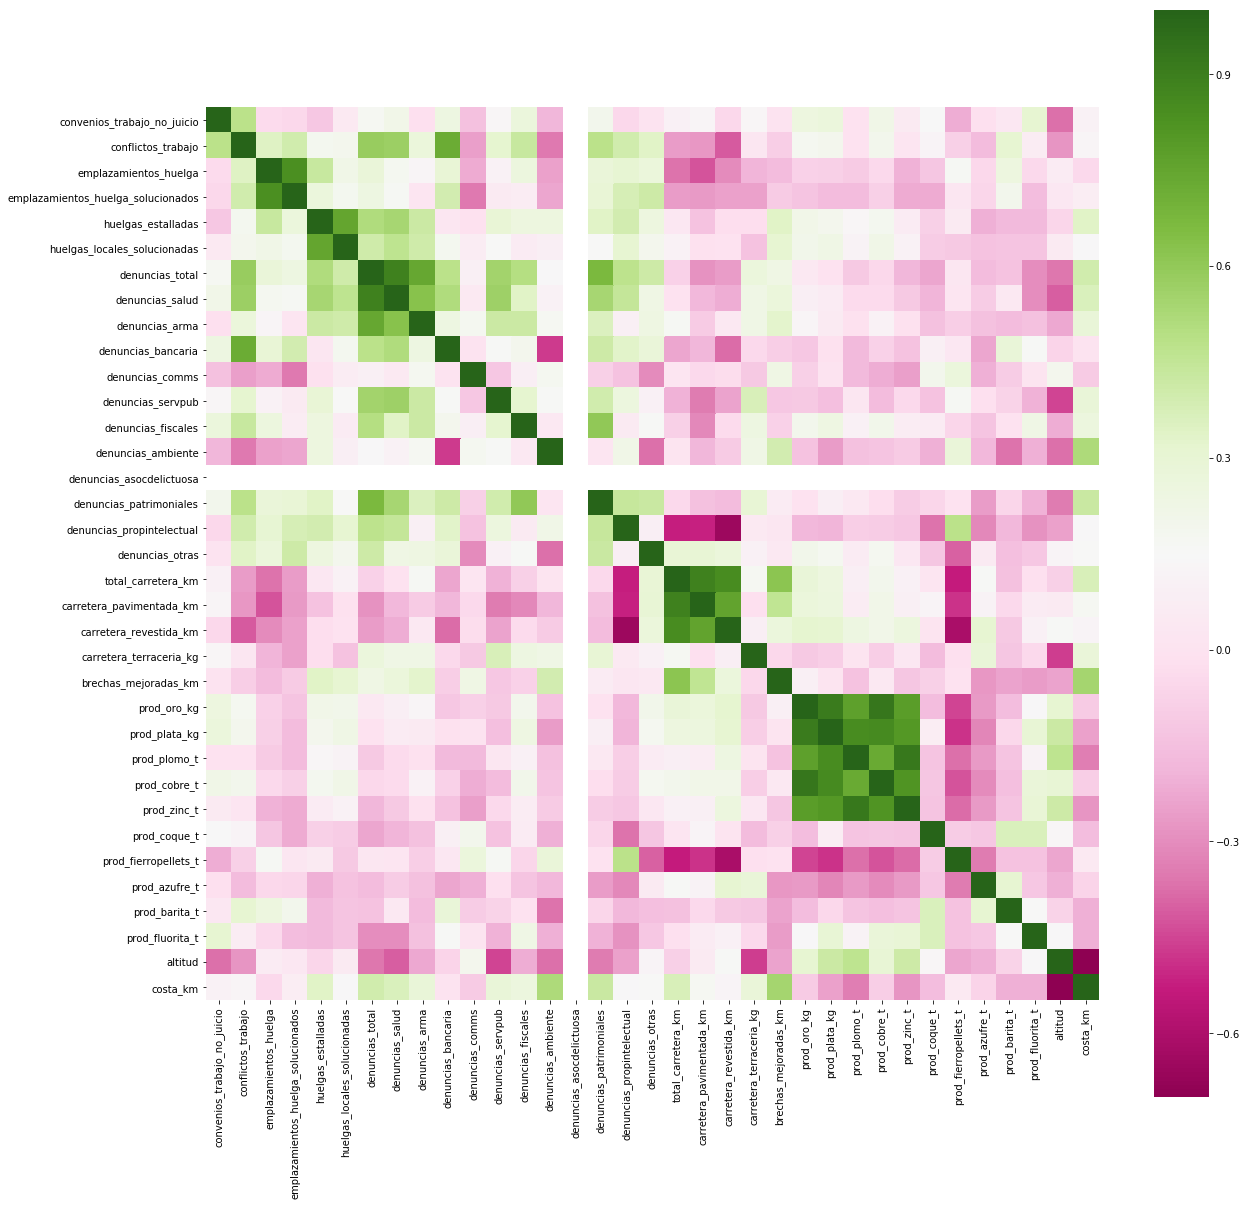

2011


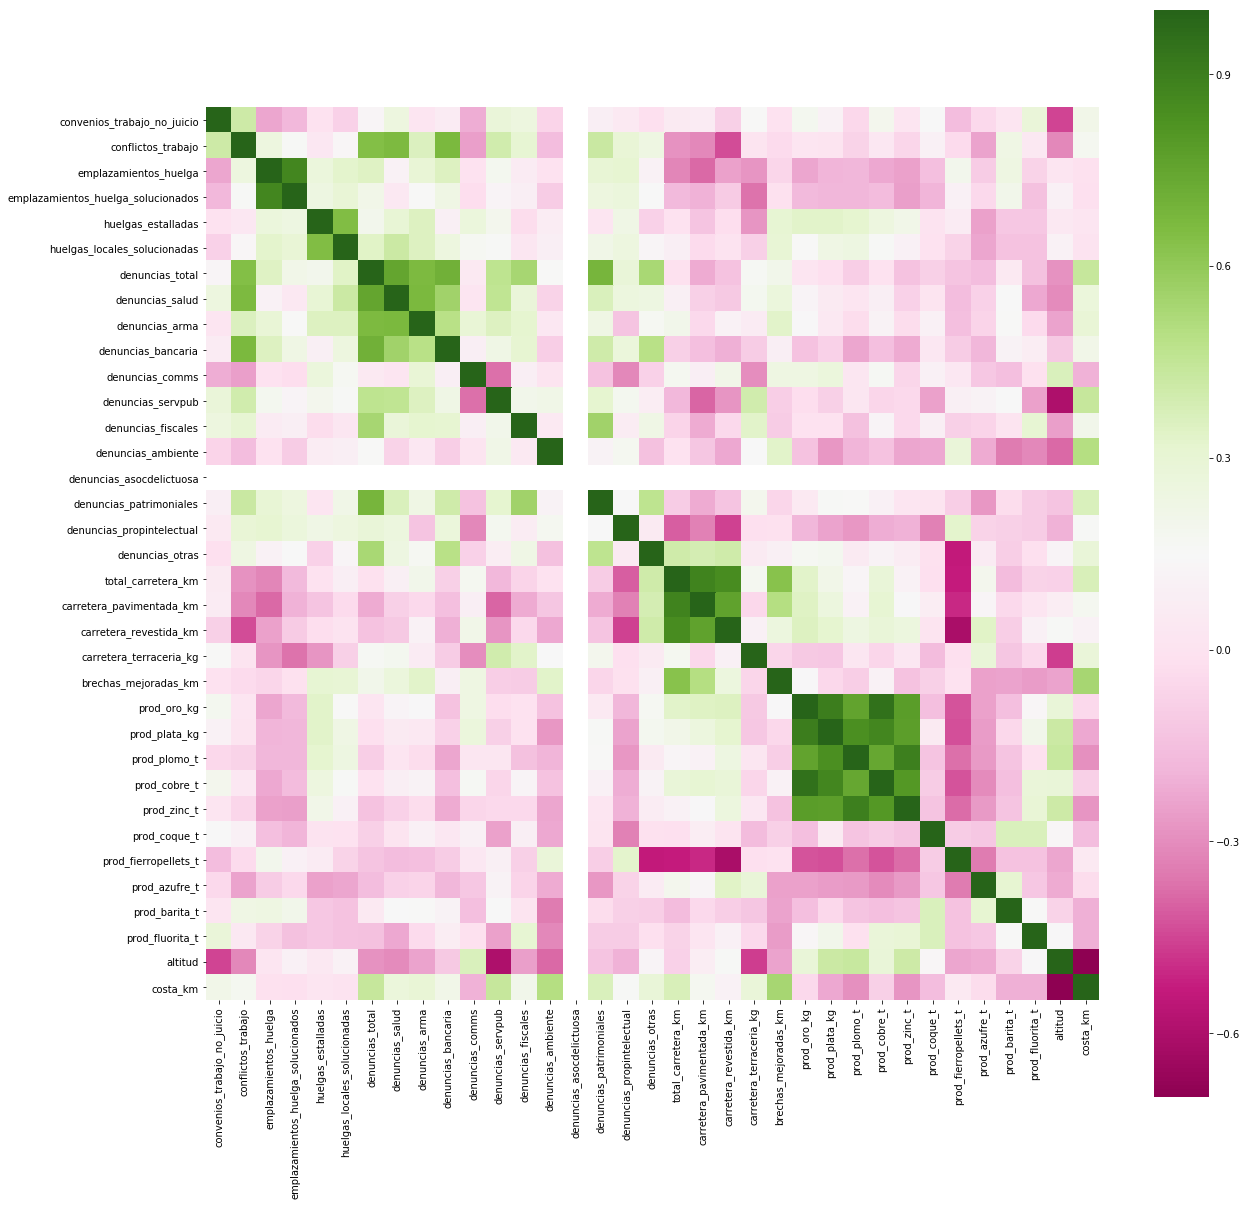

2012


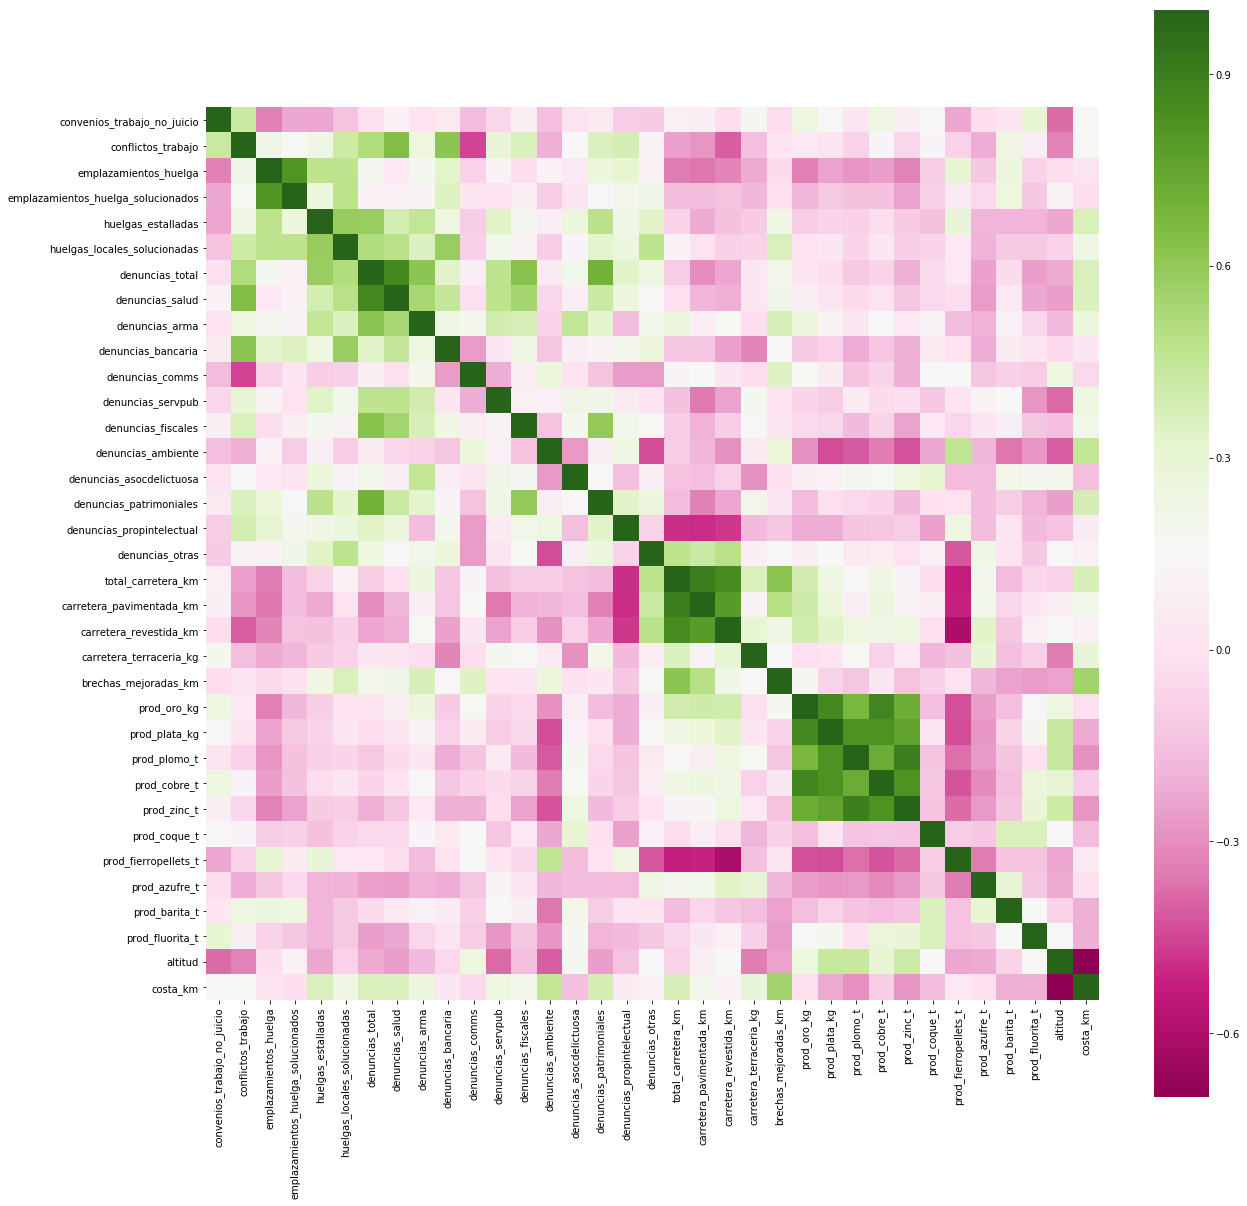

2013


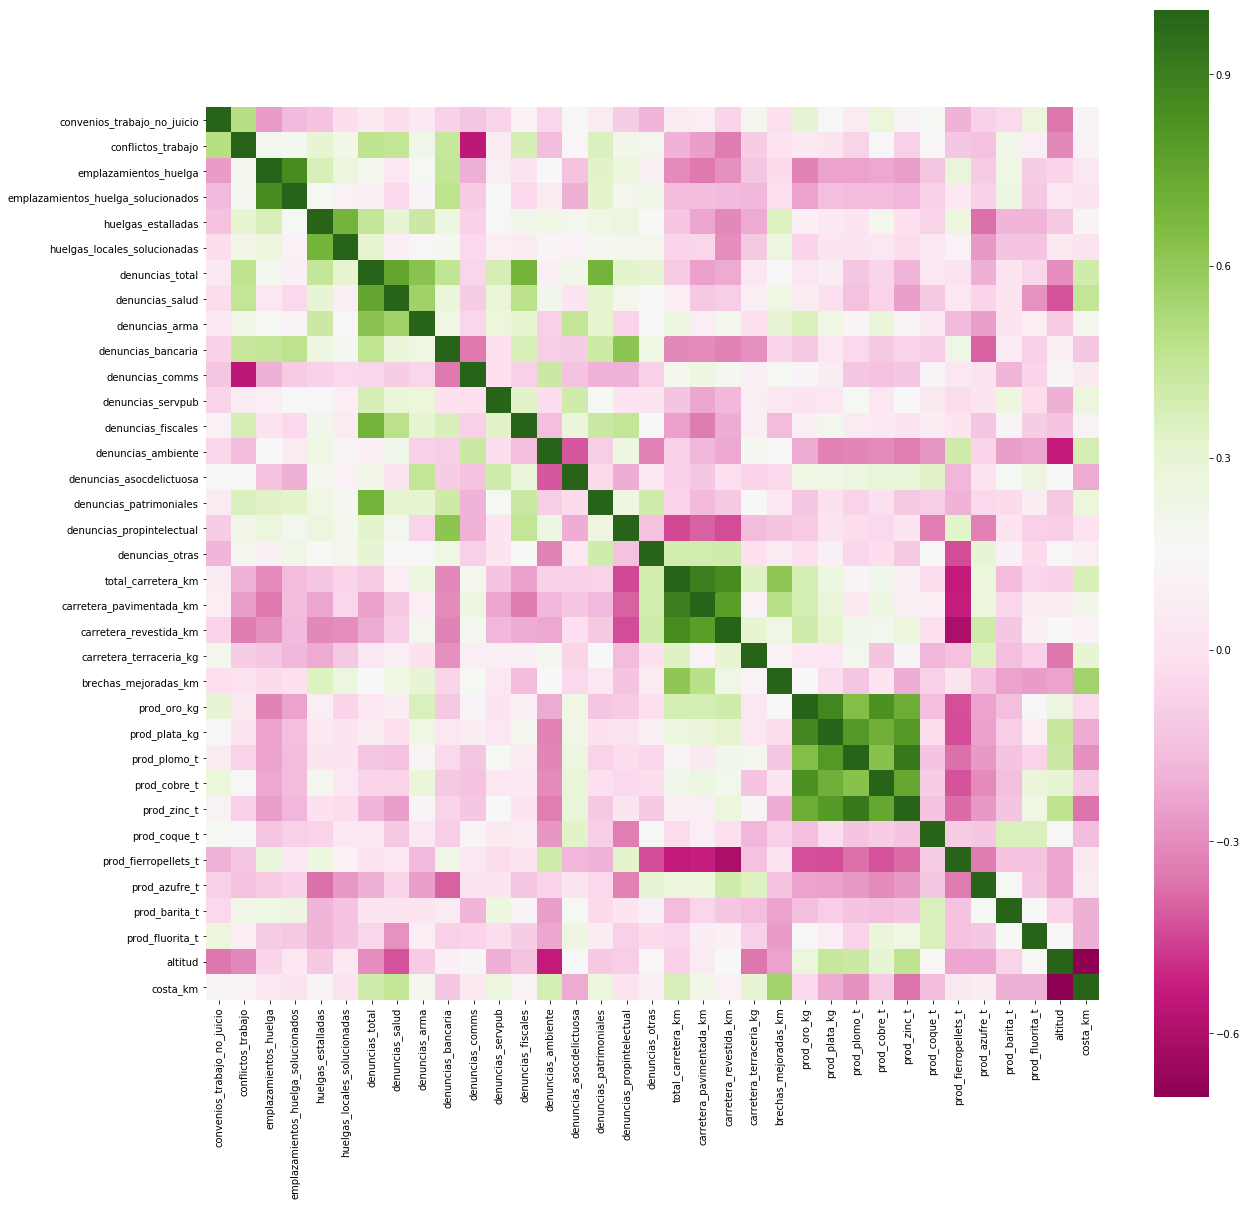

2014


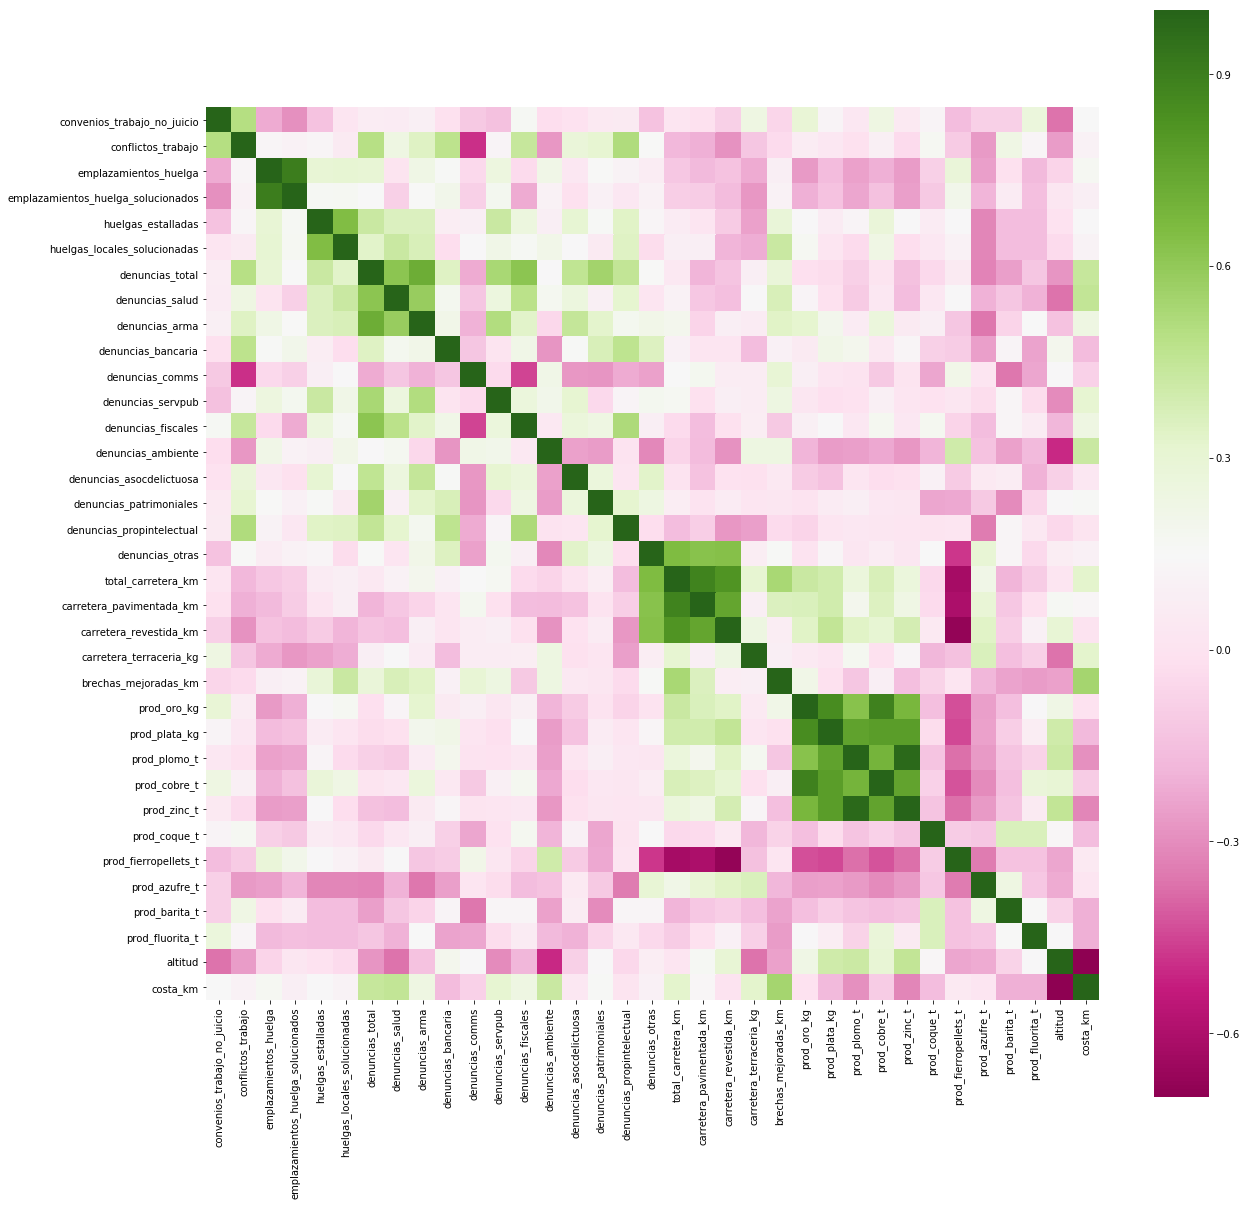

2015


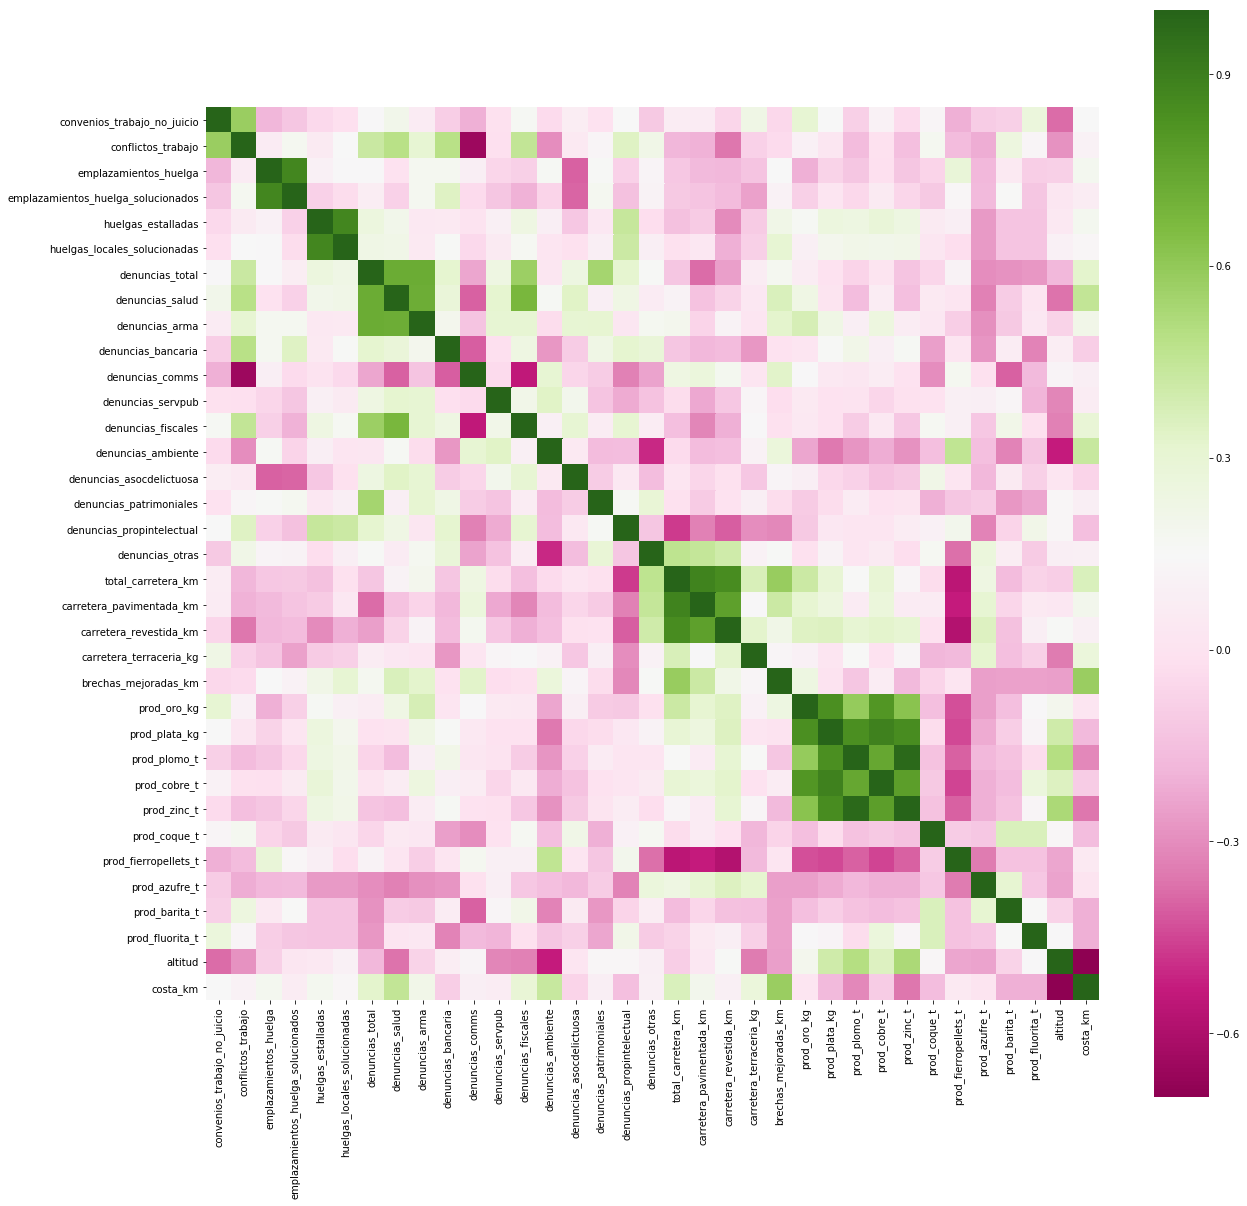

2016


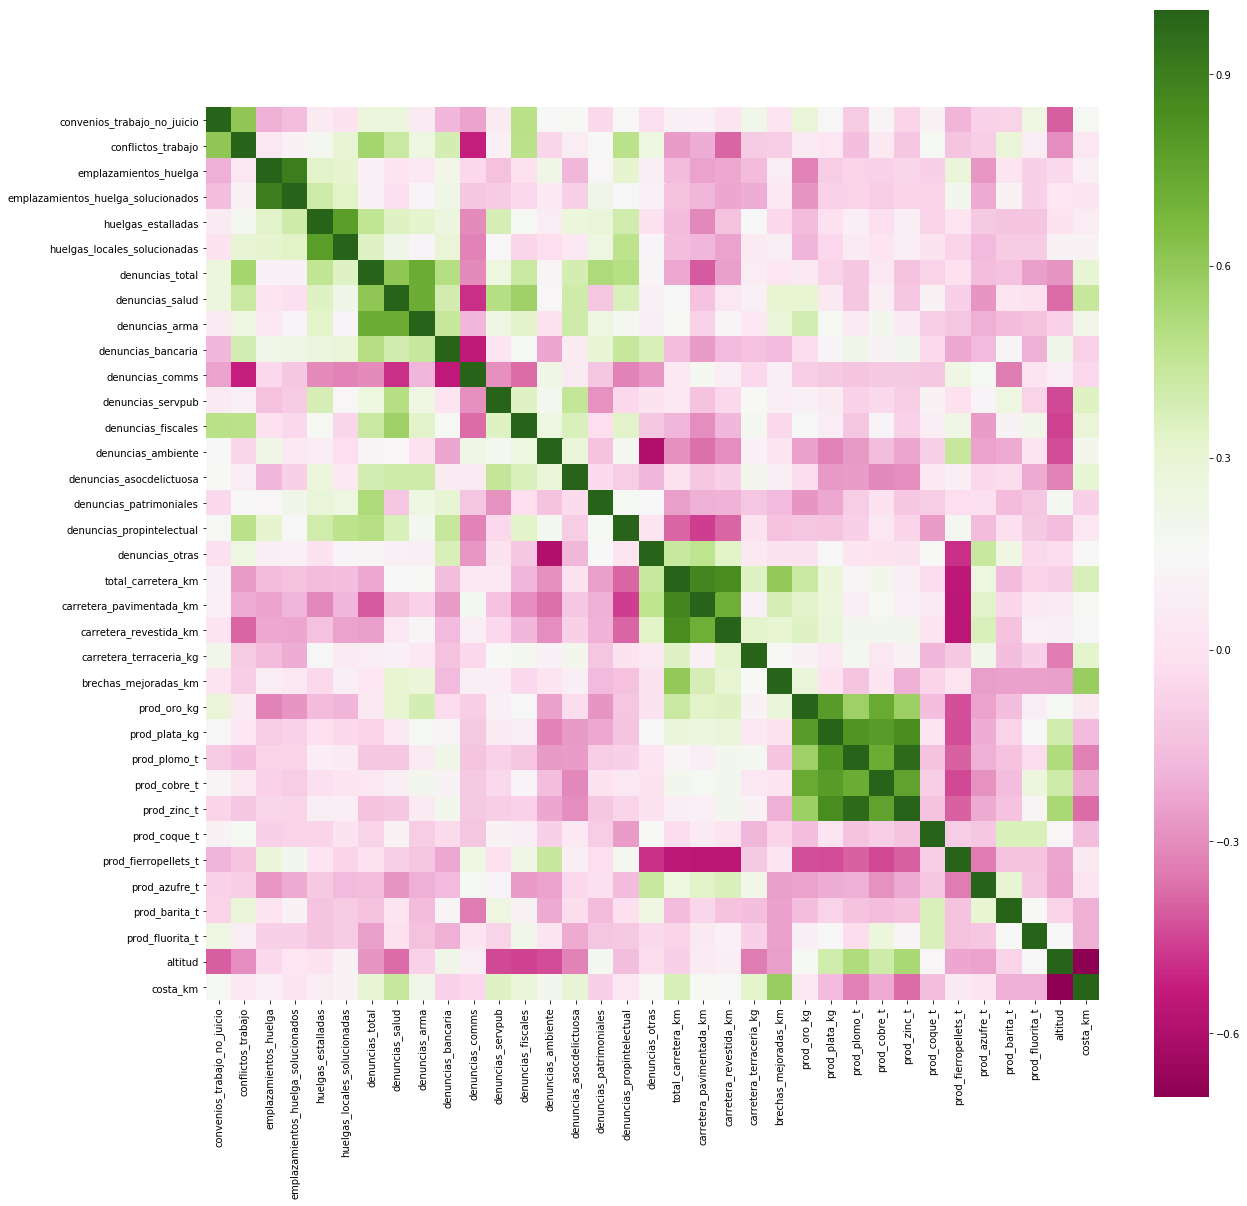

In [268]:
for df in dfs:
    print(df[4])
    epc.explore_potential_correlations(df[1])

We've got some decent correlations across all different years. Generally speaking, the metal production variables (especially oro, plata, plomo, cobre, zinc) correlate positively, as do the carretera variables, some of the denuncias variables (total, salud, arma), and some of the labor variables.

This should be ok to do a PCA analysis on. 

#### Factors chosen must account for 10% individually and 60% collectively

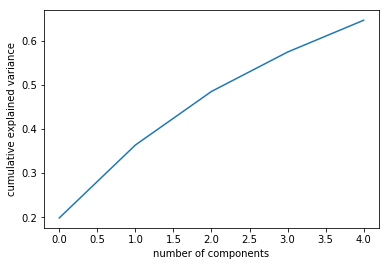

Variance explained for first 5 components in 2010
[19.82947077 36.39145437 48.56472138 57.51507736 64.74433504]



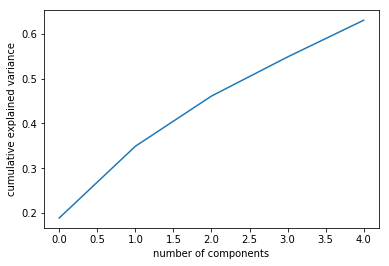

Variance explained for first 5 components in 2011
[18.86734529 34.90352841 46.13099372 54.8823166  63.09606326]



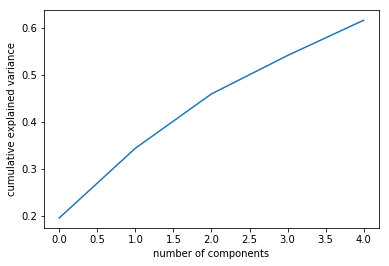

Variance explained for first 5 components in 2012
[19.55967206 34.36418349 45.89788164 54.06393525 61.54961772]



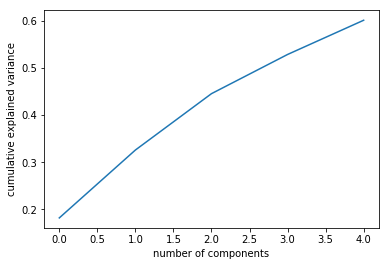

Variance explained for first 5 components in 2013
[18.17439008 32.57947453 44.54261222 52.85810249 60.12202901]



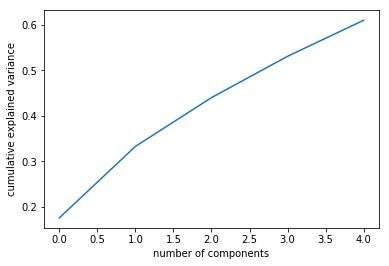

Variance explained for first 5 components in 2014
[17.49955123 33.25002043 43.99688754 53.10253958 61.04639014]



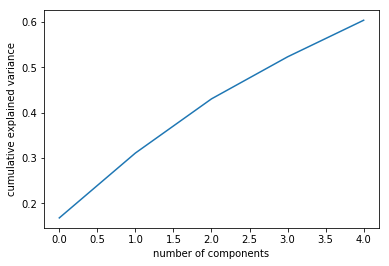

Variance explained for first 5 components in 2015
[16.77813939 31.08249976 43.02974718 52.30000064 60.36931396]



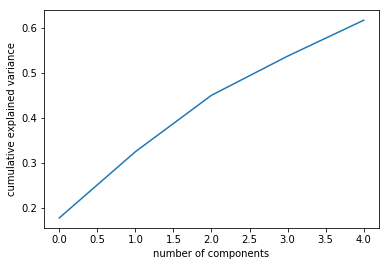

Variance explained for first 5 components in 2016
[17.78997232 32.47153701 44.98503822 53.66355317 61.62896774]



In [269]:
pca_dfs = []
for df in dfs:
    pca_df = wts.pca_df(df[0], df[2], df[3], 5, 'entidad', 'year', df[4])
    pca_dfs.append(pca_df)

Across all years, it appears that the first five factors meet the criteria outlined above: individual factors must account for 10% of variance and collectively must account for 60% of variance.

In this instance, the last two factors across all years are close enough to 10% variance and the sum of factors is a little below or a little above 60%.

It also says that eigenvalues must be greater than one, but I don't have a function to show that yet.

#### Rotate Factors

In [270]:
loadings = []
for i in range(len(dfs)):
    loading = wts.factor_loadings(dfs[i][2], dfs[i][0], pca_dfs[i], 'entidad', 'year')
    loadings.append(loading)

In [279]:
loadings[1]

,PC1,PC2,PC3,PC4,PC5
convenios_trabajo_no_juicio,0.081758,-0.259847,0.161198,-0.526018,0.157657
conflictos_trabajo,0.518173,-0.530229,-0.221339,-0.361272,-0.117040
emplazamientos_huelga,0.504108,-0.147767,-0.425014,0.367541,-0.304921
emplazamientos_huelga_solucionados,0.379195,-0.113425,-0.337728,0.407974,-0.356519
huelgas_estalladas,-0.018736,-0.440999,-0.345089,0.482667,0.206659
huelgas_locales_solucionadas,0.081245,-0.515595,-0.249608,0.471401,0.049578
denuncias_total,0.552590,-0.764345,0.034149,-0.005738,-0.113750
denuncias_salud,0.394099,-0.719650,0.053750,-0.043722,-0.054853
denuncias_arma,0.259650,-0.655093,0.091536,0.174459,-0.204208
denuncias_bancaria,0.502858,-0.526978,-0.094034,0.011610,-0.384579


In [280]:
sumdf_perc = []
for load in loadings:
    ss_df, perc_list = wts.ss_loadings(load)
    sumdf_perc.append((ss_df, perc_list))

In [281]:
sumdf_perc[0][0].head()

,PC1,PC2,PC3,PC4,PC5
convenios_trabajo_no_juicio,0.001546,0.015974,0.000525,0.047019,0.094637
conflictos_trabajo,0.051300,0.027917,0.036732,0.045838,0.012684
emplazamientos_huelga,0.034617,0.000548,0.050982,0.004871,0.086120
emplazamientos_huelga_solucionados,0.031984,0.000225,0.036314,0.017623,0.139192
huelgas_estalladas,0.033764,0.034956,0.005043,0.028662,0.052335


In [282]:
sumdf_perc[0][1]

[0.30627344863455636,
 0.2558059107957654,
 0.18802057363376473,
 0.13824153059002814,
 0.1116585363458854]

In [283]:
weights = []
for tup in sumdf_perc:
    wt_df, wt = wts.calculate_weights(tup[0], tup[1])
    weights.append((wt_df, wt))

In [284]:
weights[0][0]

,PC1,PC2,PC3,PC4,PC5,weights
convenios_trabajo_no_juicio,1.546261e-03,0.015974,0.000525,0.047019,9.463667e-02,1.192438e-01
conflictos_trabajo,5.130018e-02,0.027917,0.036732,0.045838,1.268440e-02,1.108283e-01
emplazamientos_huelga,3.461735e-02,0.000548,0.050982,0.004871,8.611996e-02,1.085126e-01
emplazamientos_huelga_solucionados,3.198363e-02,0.000225,0.036314,0.017623,1.391924e-01,1.753849e-01
huelgas_estalladas,3.376373e-02,0.034956,0.005043,0.028662,5.233490e-02,6.594289e-02
huelgas_locales_solucionadas,1.579120e-02,0.035218,0.002320,0.013283,5.758379e-02,7.255658e-02
denuncias_total,1.025115e-01,0.026355,0.006392,0.000256,3.570824e-04,2.214647e-01
denuncias_salud,8.332486e-02,0.027110,0.007379,0.000863,1.230231e-03,1.800140e-01
denuncias_arma,3.664547e-02,0.030177,0.023627,0.000767,3.176596e-04,7.916844e-02
denuncias_bancaria,4.033060e-02,0.004663,0.036303,0.049506,5.341362e-05,1.034896e-01


In [52]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
fa.analyze(pre_features, 7, rotation='varimax')

In [53]:
fa.loadings

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
year,0.068766,0.086872,0.016377,0.022765,-0.308122,-0.038561,0.064344
convenios_trabajo_no_juicio,0.055178,0.852816,-0.092321,0.015973,-0.275408,-0.042994,0.117744
conflictos_trabajo,0.448389,0.538102,-0.125578,-0.196904,0.053563,0.321294,-0.012099
emplazamientos_huelga,0.090703,-0.060680,-0.132875,-0.148299,0.617977,0.616816,-0.050536
emplazamientos_huelga_solucionados,-0.013309,-0.048222,-0.112516,-0.015469,0.369702,0.812135,-0.146203
huelgas_estalladas,0.319602,0.011345,0.064756,-0.150353,0.655814,0.042877,0.098494
huelgas_locales_solucionadas,0.138956,0.046921,-0.079388,0.188243,0.268180,-0.033346,-0.178143
denuncias_total,0.535141,0.203024,-0.053942,-0.048442,0.778772,-0.035764,0.164344
denuncias_salud,0.234957,0.158085,-0.037905,-0.013305,0.784253,0.040785,0.125610
denuncias_arma,0.137889,0.197685,0.017778,0.065404,0.486952,0.033367,0.181360


In [40]:
ev, v = fa.get_eigenvalues()

In [41]:
v

,Common_Factor_Eigenvalues
0,6.222536
1,4.385114
2,3.539593
3,2.566854
4,2.207179
5,1.912396
6,1.375561
7,0.930254
8,0.763997
9,0.636619


In [42]:
fa.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
SS Loadings,4.514397,3.704443,3.578735,3.576391,2.493695,2.706385,1.628923
Proportion Var,0.125400,0.102901,0.099409,0.099344,0.069269,0.075177,0.045248
Cumulative Var,0.125400,0.228301,0.327710,0.427055,0.496324,0.571501,0.616749
